In [59]:
import tensorflow as tf
from tensorflow.keras.applications import * #Efficient Net included here
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import pandas as pd
from sklearn import model_selection
from tqdm import tqdm
from tensorflow.keras import optimizers
import tensorflow as tf
import numpy as np

In [48]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 4)

### Solve as MultiClass Problem - 11 classes. If rerun, go to the bottom and load the model and run

#### Set up folders for modeling

In [106]:
datafolder = '../data/manual-clusters/20220430/categorized/'

newlabels = []

for label in os.listdir(datafolder):
    for image in os.listdir(datafolder + label):
        newlabels.append({
            'filename': datafolder + label + "/" + image,
            'classname': label,
            
        })
        
newlabels = pd.DataFrame(newlabels)
newlabels['class_id'] = newlabels['classname']
newlabels.replace({"class_id":{"01":"01", "02-round-end":"02","03-mib":"03","04":"04","05-hole-flat":"05",
                               "06":"06","07-honeycomb":"07","08":"08","09":"09","10-honeycombhollow":"10",
                               "11-longthin":"11"}}, inplace=True)

# Set up image directory
TRAIN_IMAGES_PATH = '../data/efNet_data/images/train'
VAL_IMAGES_PATH = '../data/efNet_data/images/val'
os.makedirs(TRAIN_IMAGES_PATH, exist_ok = True)
os.makedirs(VAL_IMAGES_PATH, exist_ok = True)

classes = set(newlabels['class_id'])
# Create directories for each class.
for class_id in classes:
    os.makedirs(os.path.join(TRAIN_IMAGES_PATH, str(class_id)), exist_ok = True)
    os.makedirs(os.path.join(VAL_IMAGES_PATH, str(class_id)), exist_ok = True)
    
def preproccess_data(df, images_path):
    for column, row in df.iterrows():
        class_id = row['class_id']
        shutil.copy(row['filename'], os.path.join(images_path, str(class_id)))
        
#Split the dataset into 80% training and 20% validation
df_train, df_valid = model_selection.train_test_split(newlabels, test_size=0.2, random_state=42, shuffle=True)
#run the  function on each of them
preproccess_data(df_train, TRAIN_IMAGES_PATH)
preproccess_data(df_valid, VAL_IMAGES_PATH)

Dataset is pretty unbalanced

In [151]:
newlabels['class_id'].value_counts()

04    417
09    152
06     68
03     59
02     57
01     56
10     50
08     28
07     19
05     17
11     10
Name: class_id, dtype: int64

#### Data Augmentations

In [109]:
input_shape = (224,224,3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)

NUMBER_OF_CLASSES = 11

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
#avoid overfitting
model.add(layers.Dropout(rate=0.2, name="dropout_out"))
# Set NUMBER_OF_CLASSES to the number of your final predictions.
model.add(layers.Dense(NUMBER_OF_CLASSES, activation="softmax", name="fc_out"))
#conv_base.trainable = False

In [110]:
height,width=224,224
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    TRAIN_IMAGES_PATH,
    # All images will be resized to target height and width.
    target_size=(height, width),
    batch_size=batch_size,
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode="categorical",
)

validation_generator = test_datagen.flow_from_directory(
    VAL_IMAGES_PATH,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode="categorical",
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2), "acc"], #'acc'
)

Found 746 images belonging to 11 classes.
Found 187 images belonging to 11 classes.


#### Model Training

In [111]:
%%time
NUMBER_OF_TRAINING_IMAGES = 746
NUMBER_OF_VALIDATION_IMAGES = 187
epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=NUMBER_OF_TRAINING_IMAGES // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=NUMBER_OF_VALIDATION_IMAGES // batch_size,
    verbose=1,
    workers=8,
    use_multiprocessing=False
)

Epoch 1/10
46/46 [==============================] - 157s 3s/step - loss: 5.8347 - top_k_categorical_accuracy: 0.3205 - acc: 0.2055 - val_loss: 5.0076 - val_top_k_categorical_accuracy: 0.2045 - val_acc: 0.1591
Epoch 2/10
46/46 [==============================] - 154s 3s/step - loss: 4.2613 - top_k_categorical_accuracy: 0.4603 - acc: 0.3082 - val_loss: 5.0486 - val_top_k_categorical_accuracy: 0.2045 - val_acc: 0.1534
Epoch 3/10
46/46 [==============================] - 134s 3s/step - loss: 4.0314 - top_k_categorical_accuracy: 0.4986 - acc: 0.3397 - val_loss: 4.2989 - val_top_k_categorical_accuracy: 0.1023 - val_acc: 0.0455
Epoch 4/10
46/46 [==============================] - 134s 3s/step - loss: 3.7357 - top_k_categorical_accuracy: 0.5192 - acc: 0.3603 - val_loss: 4.0741 - val_top_k_categorical_accuracy: 0.1989 - val_acc: 0.1250
Epoch 5/10
46/46 [==============================] - 131s 3s/step - loss: 3.5680 - top_k_categorical_accuracy: 0.5452 - acc: 0.3808 - val_loss: 5.4117 - val_top_k_ca

#### For rerun, load the model and continue

In [150]:
#model.save('./efficientNet')
#model = tf.keras.models.load_model("./efficientNet")

INFO:tensorflow:Assets written to: ./efficientNet\assets


In [112]:
y_pred = model.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)

In [149]:
print("Number of images per class")
print(newlabels['class_id'].value_counts())

Number of images per class
04    417
09    152
06     68
03     59
02     57
01     56
10     50
08     28
07     19
05     17
11     10
Name: class_id, dtype: int64


In [120]:
print('Classification Report')
target_names = ["01","02","03","04","05","06","07","08","09","10","11"]
print(classification_report(validation_generator.classes, y_pred_class, target_names=target_names, zero_division=0))

Classification Report
              precision    recall  f1-score   support

          01       0.00      0.00      0.00         9
          02       0.00      0.00      0.00        16
          03       0.00      0.00      0.00         8
          04       0.49      0.32      0.39        84
          05       0.00      0.00      0.00         8
          06       0.00      0.00      0.00         6
          07       0.00      0.00      0.00         4
          08       0.00      0.00      0.00         5
          09       0.17      0.53      0.26        30
          10       0.00      0.00      0.00        14
          11       0.00      0.00      0.00         3

    accuracy                           0.23       187
   macro avg       0.06      0.08      0.06       187
weighted avg       0.25      0.23      0.22       187



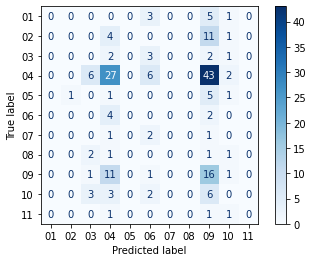

In [117]:
cm = confusion_matrix(validation_generator.classes, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
score = model.evaluate(validation_generator, verbose=1)

In [135]:
print("%s%s: %.2f%% %s: %.2f%% " % ("Evaluate: ",model.metrics_names[1], score[1]*100 ,model.metrics_names[2], score[2]*100))

Evaluate: top_k_categorical_accuracy: 43.85% acc: 21.39% 
